In [1]:
import pandas as pd
import numpy as np
from src.eda_methods import show_barplot, load_data

In [2]:
old_commits, new_commits, cc_df, bic = load_data('accumulo')

In [3]:
# selects cochange of at least two components with confidence higher that 0.5
relevant_cc =\
    cc_df[
        (cc_df.support_count > 1) & (cc_df.confidence >= 0.5)
    ].reset_index(drop=True).copy()

# frees memory
del cc_df

**Note** that the hashes for cochange are the same as in new_commits but the hashes for bug introducing commits (bic) is the same as in old_commits. Thus, we must convert bic hashes into new_commits hashes.

In [4]:
# relevant_cc.iloc[0].commit_hash[0] in new_commits.values

# drops duplicated hashes 
bic = bic[~bic.duplicated()].reset_index(drop=True)
print('Number of bug introducing hashes: {0}'.format(len(bic)))

Number of bug introducing hashes: 775


In [5]:
# creates a dataframe to support conversion of old hashes into new ones
conv_df = pd.DataFrame()
conv_df['old_hash'] = old_commits.sort_index()
conv_df['new_hash'] =\
    new_commits.sort_index()\
    .reset_index(drop=True)[
        old_commits\
        .sort_index()\
        .reset_index(drop=True)\
        .index
    ].values

In [6]:
# converts bic's old hashes into new ones
bic =\
    conv_df.set_index('old_hash')\
    .squeeze()[bic.values]\
    .reset_index(drop=True)

In [18]:
# checks if any of the commits in a cochange observation introduced bugs
overview = relevant_cc.commit_hash.apply(lambda x: True if any(y in np.sort(bic.values) for y in x) else False).describe()
overview.name = 'Result of Shallow Analysis'

In [19]:
overview

count      8267
unique        2
top       False
freq       5896
Name: Result of Shallow Analysis, dtype: object

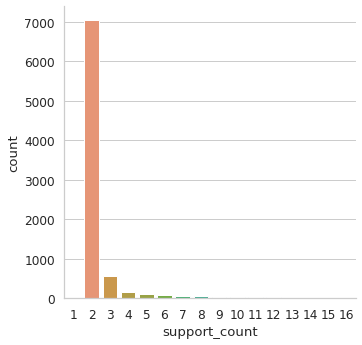

In [20]:
show_barplot(relevant_cc, 'support_count')